In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

In [2]:
NUM_PCA_COMPONENTS = 10
CROSS_VALIDATION = 10
BIN_SIZE = 20

In [3]:
df = pd.read_csv("./dataset/age_acoustic.csv")

In [4]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,age
0,0.171924,0.084798,0.191168,0.097835,0.251890,0.154055,2.158582,8.769025,0.955996,0.686715,...,0.171924,0.118349,0.043151,0.279114,1.370654,0.0,6.007764,6.007764,0.140773,28.0
1,0.119687,0.084263,0.100236,0.044716,0.184466,0.139750,0.832820,3.587928,0.972519,0.762762,...,0.119687,0.122129,0.043793,0.279114,0.730685,0.0,4.306641,4.306641,0.119247,28.0
2,0.151992,0.079224,0.147153,0.092833,0.228382,0.135548,2.086398,11.305400,0.966884,0.745067,...,0.151992,0.113303,0.043235,0.277358,1.324179,0.0,5.103369,5.103369,0.182165,28.0
3,0.165107,0.086021,0.176763,0.096534,0.249389,0.152855,2.787841,15.209603,0.964662,0.747109,...,0.165107,0.114948,0.043151,0.279114,1.379196,0.0,6.050830,6.050830,0.146071,28.0
4,0.177831,0.087909,0.206274,0.102537,0.257892,0.155355,3.057116,15.071552,0.944205,0.634907,...,0.177831,0.119130,0.043320,0.279114,1.276547,0.0,6.050830,6.050830,0.137097,28.0


In [5]:
# Divide the features and target
X, y = df[df.columns[:-1]], df['age']
# Reassign the target variables 
y = np.ceil(y/BIN_SIZE)

In [6]:
y.count()


825

In [7]:
y.value_counts()

3.0    374
2.0    299
4.0    150
6.0      2
Name: age, dtype: int64

Training the model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1123, shuffle = True)

In [9]:
pipe_svc = Pipeline([('std_scl', StandardScaler()),
                    ('pca', PCA(n_components=10)),
                    ('svc', SVC(random_state=1))])
pipe_svc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('std_scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False))])

In [10]:
print pipe_svc.score(X_test, y_test)

0.740920096852


In [11]:
from sklearn.model_selection import cross_val_score

In [12]:
scores = cross_val_score(estimator=pipe_svc,
                       X=X_train, 
                       y=y_train,
                       cv=10, 
                       n_jobs=1)
scores

/home/HDUSER/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([ 0.74418605,  0.79069767,  0.80487805,  0.70731707,  0.75609756,
        0.70731707,  0.80487805,  0.65853659,  0.8       ,  0.8       ])

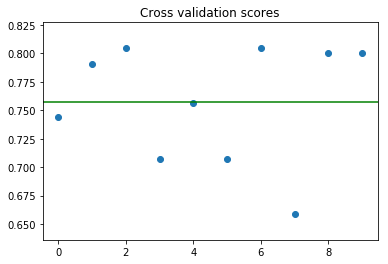

In [13]:
import matplotlib.pyplot as plt
plt.title('Cross validation scores')
plt.scatter(np.arange(len(scores)), scores)
plt.axhline(y=np.mean(scores), color='g') # Mean value of cross validation scores
plt.show()

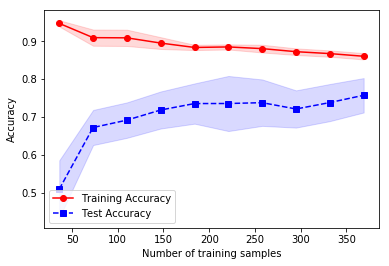

In [14]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_svc,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=10)

# Mean value of accuracy against training data
train_mean = np.mean(train_scores, axis=1)

# Standard deviation of training accuracy per number of training samples
train_std = np.std(train_scores, axis=1)

# Same as above for test data
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot training accuracies 
plt.plot(train_sizes, train_mean, color='red', marker='o', label='Training Accuracy')
# Plot the variance of training accuracies
plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='red')

# Plot for test data as training data
plt.plot(train_sizes, test_mean, color='blue', linestyle='--', marker='s', 
        label='Test Accuracy')
plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='blue')

plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

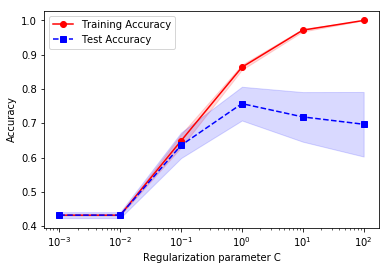

In [15]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(estimator=pipe_svc,
                                             X=X_train,
                                             y=y_train,
                                             param_name='svc__C',
                                             param_range=param_range,
                                             cv=10)

# Mean value of accuracy against training data
train_mean = np.mean(train_scores, axis=1)

# Standard deviation of training accuracy per number of training samples
train_std = np.std(train_scores, axis=1)

# Same as above for test data
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot training accuracies 
plt.plot(param_range, train_mean, color='red', marker='o', label='Training Accuracy')
# Plot the variance of training accuracies
plt.fill_between(param_range,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='red')

# Plot for test data as training data
plt.plot(param_range, test_mean, color='blue', linestyle='--', marker='s', 
        label='Test Accuracy')
plt.fill_between(param_range,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='blue')

plt.xscale('log')
plt.xlabel('Regularization parameter C')
plt.ylabel('Accuracy')
plt.legend()
plt.show()